In [1]:
%matplotlib inline

In [2]:
#@title
import jax
import numpy as np

import jax.numpy as jnp
from jax import random

try:
  import flax
except ModuleNotFoundError:
  !pip install --quiet flax
  import flax

try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial
from matplotlib import pyplot as plt

## Data Generation

In [3]:
from typing import NamedTuple, Any

def sample_data(key, bs, up=True):
  keys = random.split(key, 3)
  if up:
    x_1 = random.randint(keys[0], minval=jnp.array([0,1]), maxval=jnp.array([2,2]), shape=(bs, 2))
  else:
    x_1 = random.randint(keys[0], minval=jnp.array([0,0]), maxval=jnp.array([2,1]), shape=(bs, 2))
  x_1 = 3*(x_1.astype(jnp.float32)-0.5)
  x_1 += 4e-1*random.normal(keys[1], shape=(bs,2))
  return x_1

ndim = 2
t_0, t_1 = 0.0, 1.0
beta_0 = 0.1
beta_1 = 20.0
log_alpha = lambda t: -0.5*t*beta_0-0.25*t**2*(beta_1-beta_0)
# log_sigma = lambda t: jnp.log(jnp.sqrt(-jnp.expm1(-t*beta_0-0.5*t**2*(beta_1-beta_0))))
log_sigma = lambda t: jnp.log(t)
dlog_alphadt = jax.grad(lambda t: log_alpha(t).sum())
dlog_sigmadt = jax.grad(lambda t: log_sigma(t).sum())
# gamma_t = s_t d/dt log(s_t/alpha_t)
# gamma = lambda t: jnp.exp(log_sigma(t))*(dlog_sigmadt(t) - dlog_alphadt(t))
gamma = lambda t: (1 + 0.5*t*beta_0 + 0.5*t**2*(beta_1-beta_0))

def q_t(key, data, t):
  eps = random.normal(key, shape=data.shape)
  x_t = jnp.exp(log_alpha(t))*data + jnp.exp(log_sigma(t))*eps
  return eps, x_t

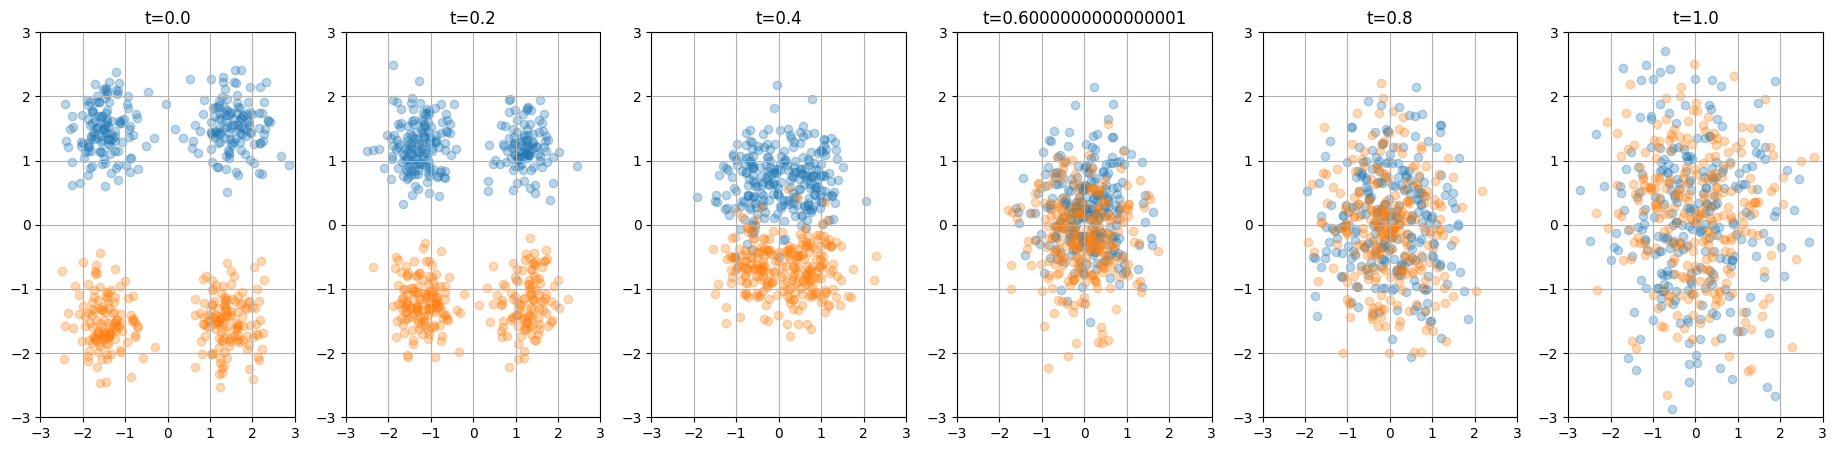

In [4]:
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
bs = 512
t_axis = np.linspace(0.0, 1.0, 6)

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 5)
  _, x_t_up = q_t(ikey[1], sample_data(ikey[0], bs//2, up=True), t_axis[i])
  _, x_t_down = q_t(ikey[3], sample_data(ikey[2], bs//2, up=False), t_axis[i])
  plt.scatter(x_t_up[:,0], x_t_up[:,1], alpha=0.3)
  plt.scatter(x_t_down[:,0], x_t_down[:,1], alpha=0.3)
  plt.title(f't={t_axis[i]}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()

## Define the Model

In [5]:
class MLP(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, t, x):
    h = jnp.hstack([t,x])
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_out)(h)
    return h

def train_model(key, data_generator):
  model = MLP(num_hid=512, num_out=ndim)
  key, init_key = random.split(key)
  optimizer = optax.adam(learning_rate=2e-4)
  state = train_state.TrainState.create(apply_fn=model.apply,
                                        params=model.init(init_key, np.ones([bs,1]), np.zeros([bs,ndim])),
                                        tx=optimizer)
  
  def sm_loss(state, key, params, bs):
    keys = random.split(key, )
    sdlogqdx = lambda _t, _x: state.apply_fn(params, _t, _x)
    data = data_generator(keys[0], bs)
    t = random.uniform(keys[1], [bs,1])
    eps, x_t = q_t(keys[2], data, t)
    loss = ((eps + sdlogqdx(t, x_t))**2).sum(1)
    return loss.mean()

  @partial(jax.jit, static_argnums=1)
  def train_step(state, bs, key):
    grad_fn = jax.value_and_grad(sm_loss, argnums=2)
    loss, grads = grad_fn(state, key, state.params, bs)
    state = state.apply_gradients(grads=grads)
    return state, loss
  
  num_iterations = 20_000
  key, loop_key = random.split(key)
  for iter in trange(num_iterations):
    state, _ = train_step(state, bs, random.fold_in(loop_key, iter))
  return state

In [6]:
key, ikey = random.split(key)
state_up = train_model(ikey, partial(sample_data, up=True))
key, ikey = random.split(key)
state_down = train_model(ikey, partial(sample_data, up=False))

100%|██████████| 20000/20000 [00:15<00:00, 1264.80it/s]


## Evaluation of the Trained Model

In [7]:
# v_t(x) = dlog(alpha)/dt x - s^2_t d/dt log(s_t/alpha_t) dlog q_t(x)/dx
# dx = (v_t(x) - xi*beta_t*dlog q_t(x)/dx)dt + sqrt(2*beta_t*xi*dt)*eps
@jax.jit
def vector_field_SDE(state,t,x):
  sdlogqdx = lambda _t, _x: state.apply_fn(state.params, _t, _x)
  dxdt = dlog_alphadt(t)*x - 2*gamma(t)*sdlogqdx(t, x)
  return dxdt

# v_t(x) = dlog(alpha)/dt x - s^2_t d/dt log(s_t/alpha_t) dlog q_t(x)/dx
@jax.jit
def vector_field(key,t,x,state):
  eps = jax.random.randint(key, x.shape, 0, 2).astype(float)*2 - 1.0
  sdlogqdx = lambda _x: state.apply_fn(state.params, t, _x)
  sdlogdx_val, jvp_val = jax.jvp(sdlogqdx, (x,), (eps,))
  return sdlogdx_val, (jvp_val*eps).sum(1, keepdims=True)

def generate_samples(key, state):
  dt = 1e-2
  t = 1.0
  n = int(t/dt)
  t = t*jnp.ones((bs,1))
  key, ikey = random.split(key, num=2)
  x_gen = jnp.zeros((bs,n+1,ndim))
  x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, ndim)))
  for i in trange(n):
    key, ikey = random.split(key, num=2)
    dx = -dt*vector_field_SDE(state, t, x_gen[:,i,:]) + jnp.sqrt(2*jnp.exp(log_sigma(t))*gamma(t)*dt)*random.normal(ikey, shape=(bs,2))
    x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
    t += -dt
  return x_gen

### Model up

100%|██████████| 100/100 [00:00<00:00, 119.46it/s]


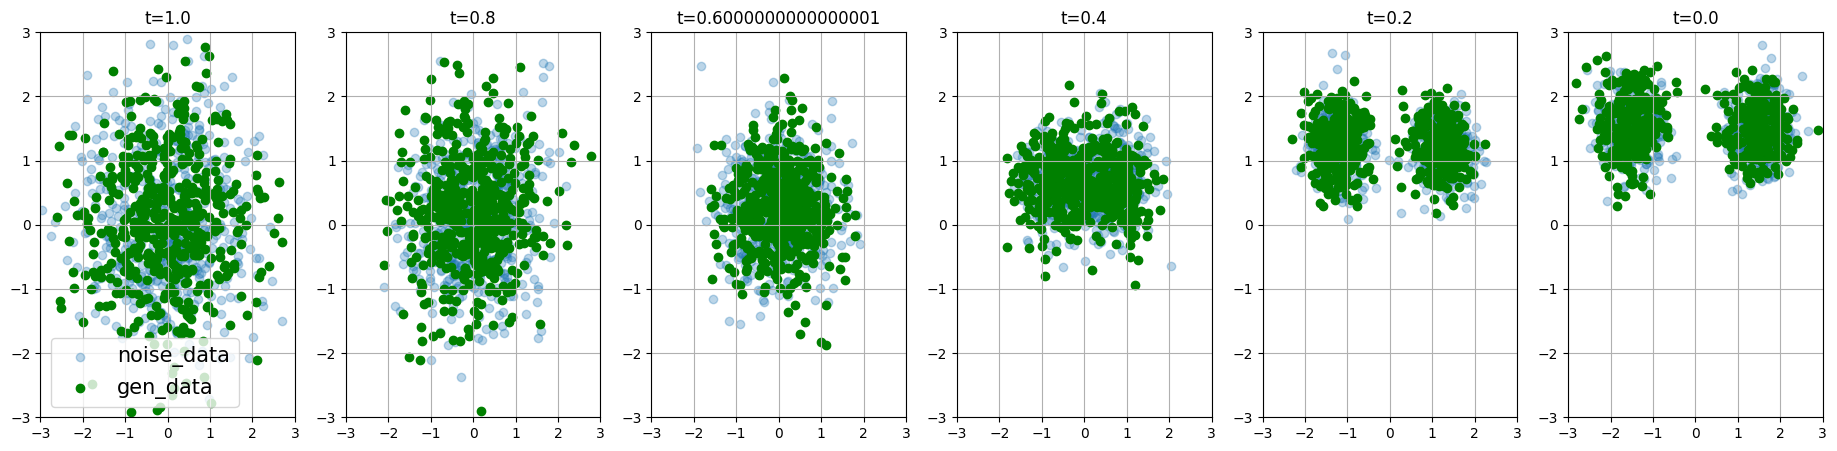

In [8]:
key, ikey = random.split(key)
x_gen = generate_samples(ikey, state_up)
x_gen_up = jnp.copy(x_gen[:,-1,:])

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs, up=True), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data', alpha=0.3)
  plt.scatter(x_gen[:,int(x_gen.shape[1]*(t_axis[i])),0], x_gen[:,int(x_gen.shape[1]*(t_axis[i])),1], label='gen_data', color='green')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

### Model down

100%|██████████| 100/100 [00:00<00:00, 237.73it/s]


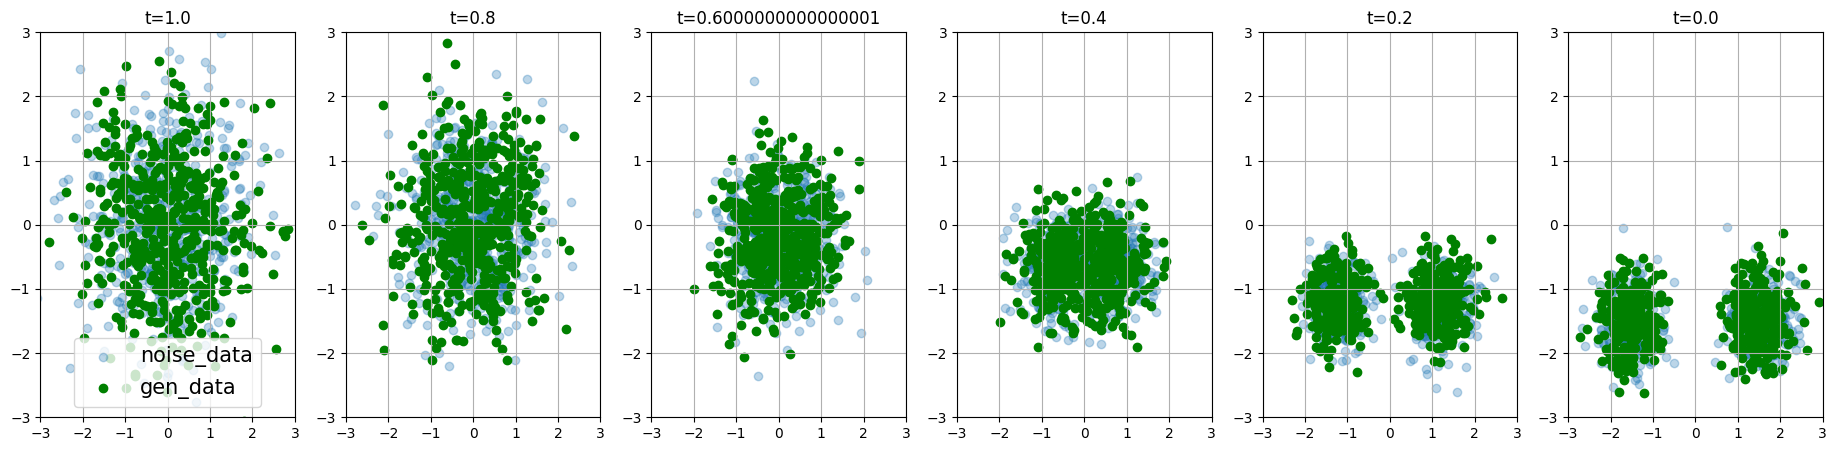

In [9]:
key, ikey = random.split(key)
x_gen = generate_samples(ikey, state_down)
x_gen_down = jnp.copy(x_gen[:,-1,:])

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs, up=False), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data', alpha=0.3)
  plt.scatter(x_gen[:,int(x_gen.shape[1]*(t_axis[i])),0], x_gen[:,int(x_gen.shape[1]*(t_axis[i])),1], label='gen_data', color='green')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

## Adding vector fields

In [10]:
bs = 512

dt = 1e-3
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1]))/np.sqrt(2))
for i in trange(n):
  x_t = x_gen[:,i,:]
  key, ikey = random.split(key, num=2)
  sdlogdx_1, divdlog_1 = vector_field(ikey,t,x_t,state_up)
  sdlogdx_2, divdlog_2 = vector_field(ikey,t,x_t,state_down)
  dxdt = dlog_alphadt(t)*x_t - gamma(t)*(sdlogdx_1+sdlogdx_2)
  x_gen = x_gen.at[:,i+1,:].set(x_t - dt*dxdt)
  t += -dt
  
x_gen_avg = jnp.copy(x_gen)

100%|██████████| 1000/1000 [00:10<00:00, 98.10it/s]


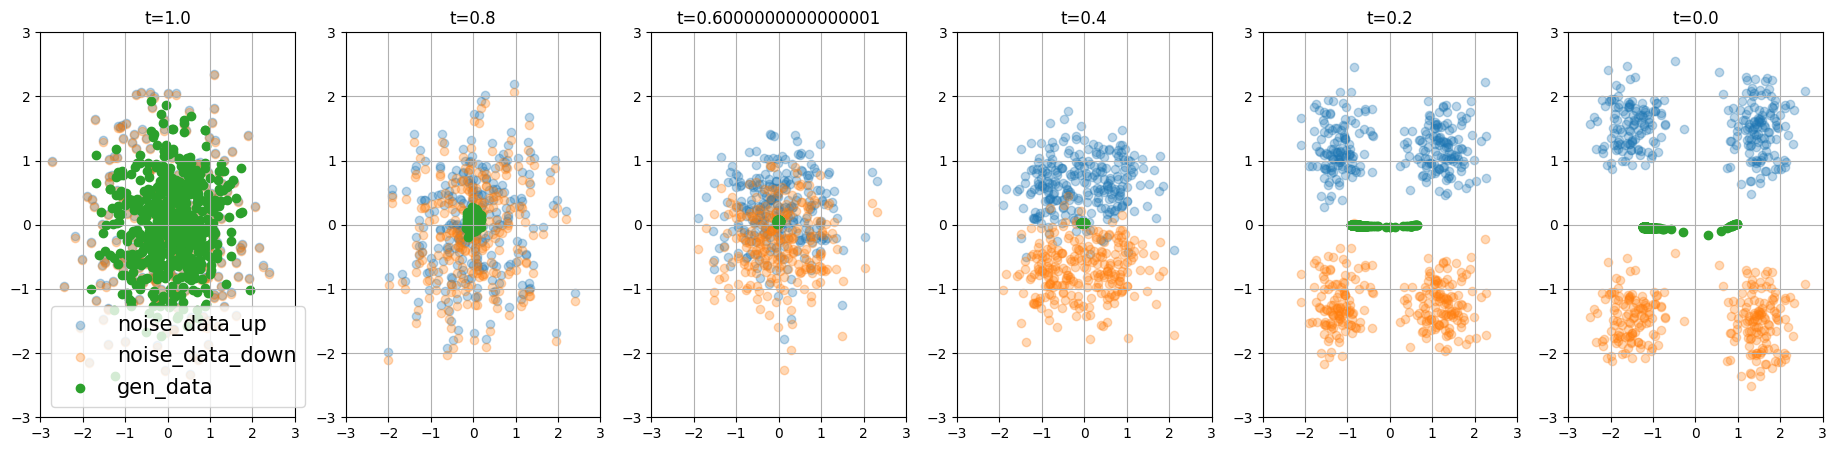

In [11]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=True), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_up', alpha=0.3)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=False), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_down', alpha=0.3)
  plt.scatter(x_gen[:,int(n*(t_axis[i])),0], x_gen[:,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

## Averaging vector fields

In [12]:
bs = 512

dt = 1e-3
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1]))/np.sqrt(2))
for i in trange(n):
  x_t = x_gen[:,i,:]
  key, ikey = random.split(key, num=2)
  sdlogdx_1, divdlog_1 = vector_field(ikey,t,x_t,state_up)
  sdlogdx_2, divdlog_2 = vector_field(ikey,t,x_t,state_down)
  dxdt = dlog_alphadt(t)*x_t - gamma(t)*0.5*(sdlogdx_1+sdlogdx_2)
  x_gen = x_gen.at[:,i+1,:].set(x_t - dt*dxdt)
  t += -dt
  
x_gen_avg = jnp.copy(x_gen)

100%|██████████| 1000/1000 [00:08<00:00, 115.11it/s]


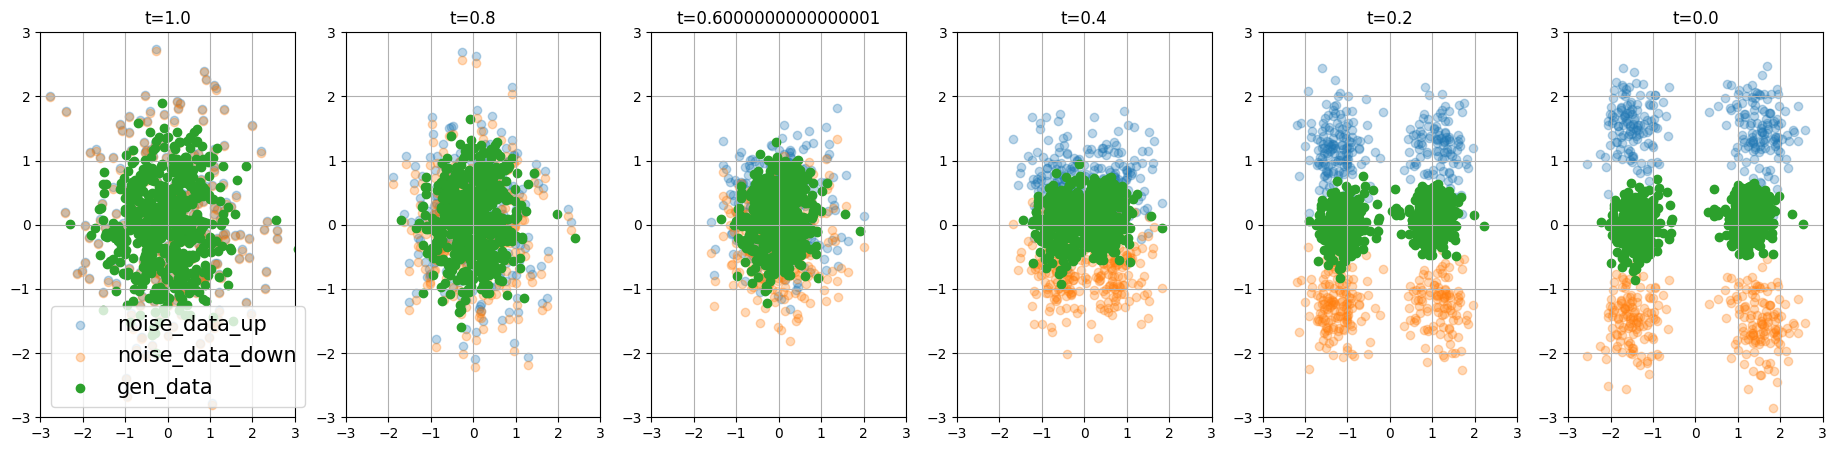

In [13]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=True), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_up', alpha=0.3)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=False), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_down', alpha=0.3)
  plt.scatter(x_gen[:,int(n*(t_axis[i])),0], x_gen[:,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

## Product

In [27]:
# def sample_uniform(bs, start, u0=0.0, u1=1.0):
#     u = (start + jnp.sqrt(2)*jnp.arange(bs*jax.device_count()+1)) % 1
#     start=u[-1]
#     u = (u1-u0)*u[jax.process_index()*bs:(jax.process_index()+1)*bs] + u0
#     return u, start

from scipy.stats import qmc
sampler = qmc.Sobol(d=1, scramble=False)

def sample_cat(bs, next_u, logits):
    # u, next_u = sample_uniform(bs, next_u)
    u = sampler.random(bs).squeeze()
    bins = jnp.cumsum(nn.softmax(logits))
    ids = jnp.digitize(u, bins)
    return ids, next_u

@partial(jax.jit, static_argnums=0)
def sample_cat_sys(bs, key, logits):
    u = jax.random.uniform(key, shape=(1,))
    u = (u + 1/bs*jnp.arange(bs)) % 1
    bins = jnp.cumsum(nn.softmax(logits))
    ids = jnp.digitize(u, bins)
    return ids, None

In [31]:
@jax.jit
def sdlogqdx_fn(state, t,x):
  return state.apply_fn(state.params, t, x)

resample = True
dt = 1e-3
next_u = 0.5
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1]))/np.sqrt(2))
w_gen = jnp.zeros((bs,n+1,1))
for i in trange(n):
  key, *ikey = random.split(key, num=3)
  sdlogqdx_up = sdlogqdx_fn(state_up, t, x_gen[:,i,:])
  sdlogqdx_down = sdlogqdx_fn(state_down, t, x_gen[:,i,:])
  dx = dt*(-dlog_alphadt(t)*x_gen[:,i,:] + 2*gamma(t)*(sdlogqdx_up + sdlogqdx_down)) 
  dx += jnp.sqrt(2*gamma(t)*jnp.exp(log_sigma(t))*dt)*random.normal(ikey[0], shape=(bs,2))
  x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  dw = dt*(2*dlog_alphadt(t) + 2*gamma(t)/jnp.exp(log_sigma(t))*(sdlogqdx_up*sdlogqdx_down).sum(1, keepdims=True))
  w_gen = w_gen.at[:,i+1,:].set(w_gen[:,i,:] + dw)
  if resample:
    # new_ids = jax.random.choice(ikey[1], bs, (bs,), p=nn.softmax(w_gen[:,i+1,0]))
    # new_ids, next_u = sample_cat(bs, next_u, w_gen[:,i+1,0])
    new_ids, _ = sample_cat_sys(bs, ikey[1], w_gen[:,i+1,0])
    x_gen = x_gen.at[:,i+1,:].set(x_gen[new_ids,i+1,:])
    w_gen = w_gen.at[:,i+1,:].set(0)
  t += -dt

100%|██████████| 1000/1000 [00:23<00:00, 42.47it/s]


## Systematic Resampling

<Figure size 640x480 with 0 Axes>

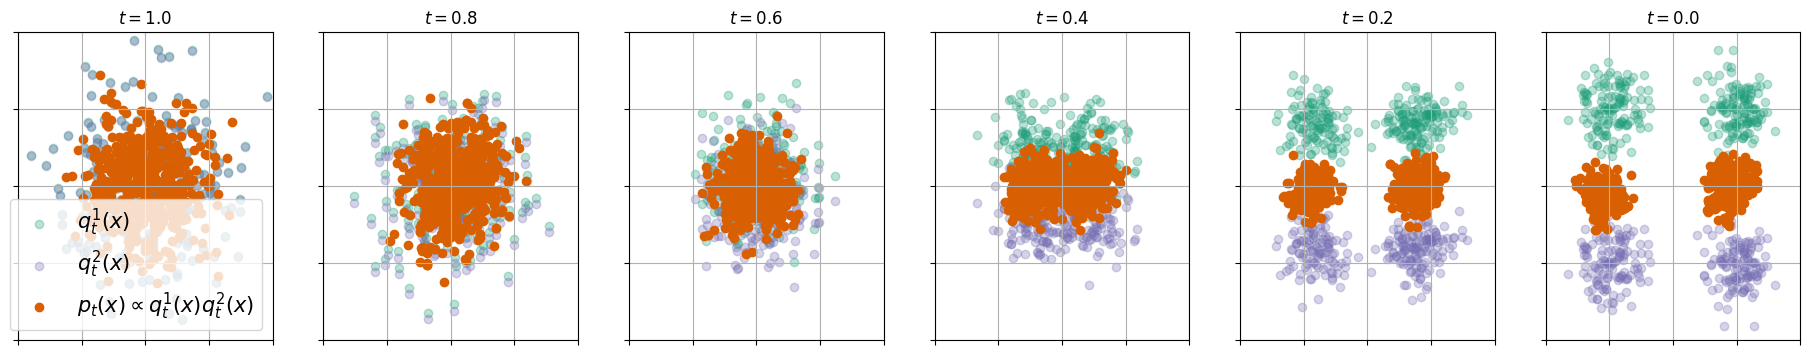

In [38]:
C1="#1D9D79"
C2="#756FB3"
C3="#D96002"


t_axis = np.linspace(0.0, 1.0, 6)
# t_axis = np.linspace(1e-2, 1.0, 6)
plt.tight_layout()
plt.figure(figsize=(23,4))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 4)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=True), t)
  plt.scatter(x_t[:,0], x_t[:,1], label=r'$q_t^1(x)$', alpha=0.3, c=C1)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=False), t)
  plt.scatter(x_t[:,0], x_t[:,1], label=r'$q_t^2(x)$', alpha=0.3, c=C2)
  if resample:
    ids = jnp.arange(bs)
  else:
    # ids = jax.random.choice(ikey[2], bs, (bs,), p=nn.softmax(w_gen[:,int(n*(t_axis[i])),0]))
    ids, next_u = sample_cat(bs, next_u, w_gen[:,int(n*(t_axis[i])),0])
  
  plt.scatter(x_gen[ids,int(n*(t_axis[i])),0], x_gen[ids,int(n*(t_axis[i])),1], c=C3, label=r'$p_{t}(x)\propto q_t^1(x)q_t^2(x)$')
  plt.xticks(np.linspace(-3,3,5),[])
  plt.yticks(np.linspace(-3,3,5),[])
  plt.title(rf'$t={t:1.1f}$')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)
    
plt.savefig('toy_product.pdf', bbox_inches='tight')

## QMC

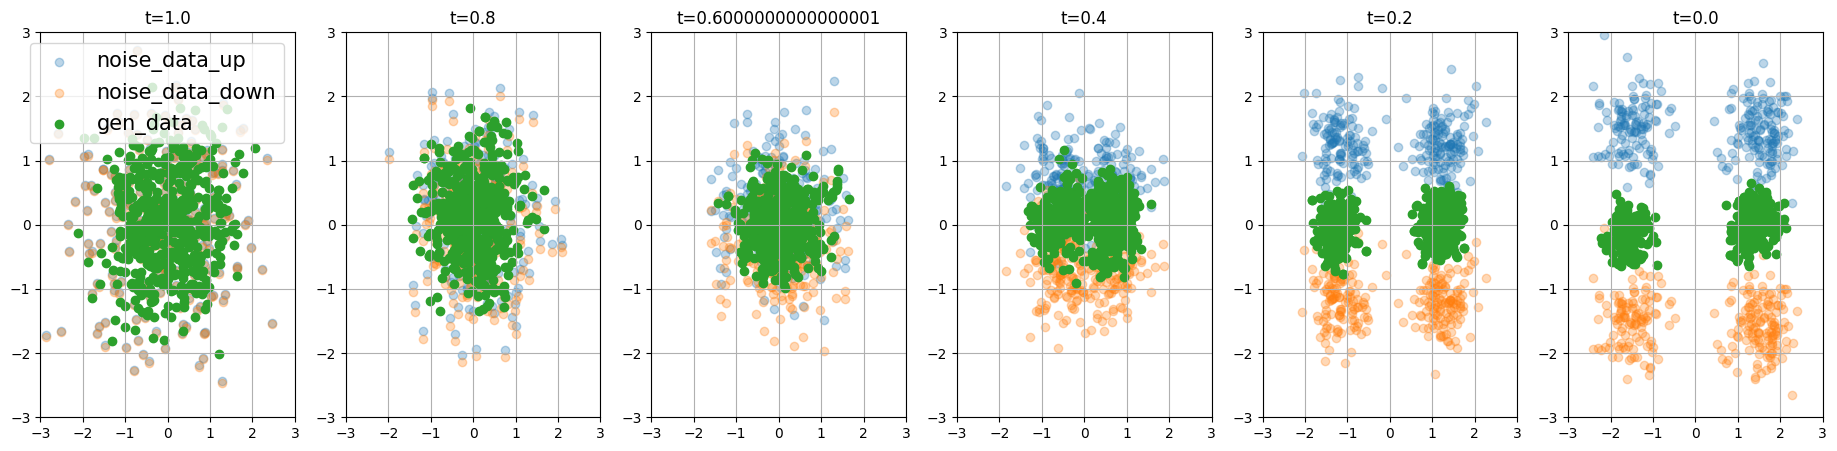

In [17]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 4)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=True), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_up', alpha=0.3)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=False), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_down', alpha=0.3)
  if resample:
    ids = jnp.arange(bs)
  else:
    # ids = jax.random.choice(ikey[2], bs, (bs,), p=nn.softmax(w_gen[:,int(n*(t_axis[i])),0]))
    ids, next_u = sample_cat(bs, next_u, w_gen[:,int(n*(t_axis[i])),0])
  plt.scatter(x_gen[ids,int(n*(t_axis[i])),0], x_gen[ids,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)